In [5]:
cd /SMART_101

/SMART_101


In [96]:
import os
import csv
import torch
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.image import imread
from transformers.image_utils import load_image
from models.Idefics2.processing_idefics2 import Idefics2Processor
from models.Idefics2.modeling_idefics2 import Idefics2ForConditionalGeneration

# Argument
target_pid, target_insid = str(7), str(2)
mode = 'our_model' #, 'our_model', 'pretrained'
pretrained_path = "HuggingFaceM4/idefics2-8b"
our_model_path = "checkpoints/GT_with_rationale_15_shot/checkpoint-4"
data_root_path = "/data/SMART101-release-v1/SMART101-Data/"
img_root_path = f"./V_COT_output/sample/puzzle_{target_pid}_e_{target_insid}.png/"
target_img_name = f'puzzle_{target_pid}_e_{target_insid}.png'
pretrained_device = 'cuda:0'
ours_device = 'cuda:1'

In [89]:
# Function
def read_csv(csvfilename, puzzle_id):

    qa_info = []
    option = ["A", "B", "C", "D", "E"]
    with open(csvfilename, newline="") as csvfile:
        datareader = csv.DictReader(csvfile)
        for row in datareader:
            
            row["puzzle_id"] = str(puzzle_id)
            if len(row["A"]) == 0:
                row["A"] = "A"
                row["B"] = "B"
                row["C"] = "C"
                row["D"] = "D"
                row["E"] = "E"
            qa_info.append(row)
            
            # create an option column
            row["Option"] = " / ".join([f"{o}: {row[o]}" for o in option])
    return qa_info

def img_show(img_path):
    img = imread(img_path)
    plt.imshow(img)
    plt.grid(False)
    plt.axis('off')
    plt.show()

In [9]:
# 모델 & 토크나이저
if mode == 'pretrained':
    model_path = pretrained_path
elif mode == 'our_model':
    model_path = our_model_path
processor = Idefics2Processor.from_pretrained(pretrained_path,
                                                do_image_splitting = True,
                                                size= {"longest_edge": 448, "shortest_edge": 378})

pretrained_model = Idefics2ForConditionalGeneration.from_pretrained(pretrained_path, 
                                                            torch_dtype=torch.bfloat16,
                                                            low_cpu_mem_usage=True).to(pretrained_device)
our_model = Idefics2ForConditionalGeneration.from_pretrained(our_model_path, 
                                                            torch_dtype=torch.bfloat16,
                                                            low_cpu_mem_usage=True).to(ours_device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


In [99]:
# 데이터
puzzle_info = read_csv(os.path.join(data_root_path, target_pid, f"puzzle_{target_pid}.csv"), target_pid)
target_puzzle_info = puzzle_info[int(target_insid)-1]
print(f'Pid: {7}, Num of Instance: {len(puzzle_info)}')
print(f'Pid: {10}, Num of Instance: {len(puzzle_info)}')
print(puzzle_info[int(target_insid)].keys())

Pid: 7, Num of Instance: 2000
Pid: 10, Num of Instance: 2000
dict_keys(['id', 'Question', 'image', 'A', 'B', 'C', 'D', 'E', 'Answer', 'Note', 'puzzle_id', 'Option'])


puzzle_7_e_2.png
/data/SMART101-release-v1/SMART101-Data/7/img/puzzle_7_e_2.png
In an imaginary virtual world, you can get 3 mailboxes for 1 ball (top of the figure), and get 1 mailbox for 2 umbrellas (bottom of the figure). How many umbrella (or umbrellas) can you get for 2 balls?
A: 12 / B: 10 / C: 16 / D: 9 / E: 13
GT: A


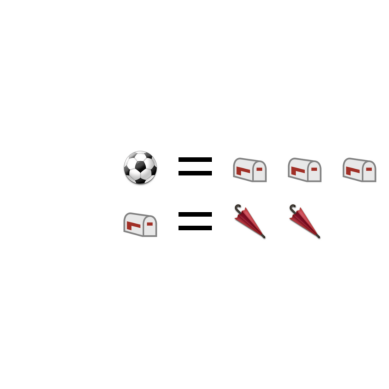

In [100]:
# 타겟 데이터 샘플
target_img_path = os.path.join(data_root_path, target_pid, 'img')
target_img_path = os.path.join(target_img_path, target_img_name)
question, option, GT = target_puzzle_info['Question'], target_puzzle_info['Option'], target_puzzle_info['Answer']
print(target_img_name)
print(target_img_path)
print(question)
print(option)
print('GT:',GT)
img_show(target_img_path)

In [142]:
# 7번 질문 & 이미지
question_dict=dict()

question_dict['Q1'] = f"Describe the image and identify the specific information."
question_dict['Q2'] = f"How many mailboxes does one ball trade for?"
question_dict['Q3'] = f"So, how many umbrellas does one mailbox trade for?"
question_dict['Q4'] = f"How many umbrellas does two balls trade for based on earlier trade relationship? Please answer with a commentary."
# question_dict['Q4'] = f"Please refer to the image and answer the aforementioned trade relationship."

question_dict['I1'] = Image.open(os.path.join(img_root_path, "I1.png"))
question_dict['I2'] = Image.open(os.path.join(img_root_path, "I1.png"))
question_dict['I3'] = Image.open(os.path.join(img_root_path, "I1.png"))
question_dict['I4'] = Image.open(os.path.join(img_root_path, "I1.png"))

In [ ]:
# 10번 질문 & 이미지
question_dict=dict()
# question_dict['Q1'] = f"Describe the image and identify the specific information needed to solve the following question.\nQuestion: {question}"
# question_dict['Q2'] = f"Make an equation using the expression symbol at the top left and the numbers in the image."
# question_dict['Q3'] = f"Similarly, use the symbol at the top left to match the number that will fit in the black square."
# question_dict['Q4'] = f"Finally, please answer the number that will be in the ? mark using the number of the black square you obtained earlier."

question_dict['Q1'] = f"Describe the image and identify the specific information."
question_dict['Q2'] = f"Use the symbol at the top-left to make an equation to match the number at the bottom-right."
question_dict['Q3'] = f"Similarly, to match the numbers at the bottom-right, use the symbols at the top-left to calculate the numbers that will fit in the black square at the top-right."
question_dict['Q4'] = f"Finally, please answer what number is covered by the question mark using the number of the black square you obtained earlier."

question_dict['I1'] = Image.open(os.path.join(img_root_path, "I1.png"))
question_dict['I2'] = Image.open(os.path.join(img_root_path, "I2.png"))
question_dict['I3'] = Image.open(os.path.join(img_root_path, "I3.png"))
question_dict['I4'] = Image.open(os.path.join(img_root_path, "I4.png"))

In [143]:
# 프롬프트
def get_prompt_format():
    first_prompt = [
        
        # First-Turn
        {"role": "user",
        "content": [
                {"type": "image"},
                {"type": "text", "text": f"{question_dict['Q1']}"},
                ]},
    ]

    second_prompt = [
        
        # First-Turn
        {"role": "user",
        "content": [
                {"type": "image"},
                {"type": "text", "text": f"{question_dict['Q1']}"},
                ]},
        {"role": "assistant",
        "content": [
            {"type": "text", "text": ''}
        ]},
        
        # Second-Turn
        {"role": "user",
        "content": [
                {"type": "image"},
                {"type": "text", "text": f"{question_dict['Q2']}"},
                ]},
    ]

    third_prompt = [
        
        # First-Turn
        {"role": "user",
        "content": [
                {"type": "image"},
                {"type": "text", "text": f"{question_dict['Q1']}"},
                ]},
        {"role": "assistant",
        "content": [
            {"type": "text", "text": ''}
        ]},
        
        # Second-Turn
        {"role": "user",
        "content": [
                {"type": "image"},
                {"type": "text", "text": f"{question_dict['Q2']}"},
                ]},
        {"role": "assistant",
        "content": [
            {"type": "text", "text": ''}
        ]},
        
        # Third-Turn
        {"role": "user",
        "content": [
                {"type": "image"},
                {"type": "text", "text": f"{question_dict['Q3']}"},
                ]},
    ]

    fourth_prompt = [
        
        # First-Turn
        {"role": "user",
        "content": [
                {"type": "image"},
                {"type": "text", "text": f"{question_dict['Q1']}"},
                ]},
        {"role": "assistant",
        "content": [
            {"type": "text", "text": ''}
        ]},
        
        # Second-Turn
        {"role": "user",
        "content": [
                {"type": "image"},
                {"type": "text", "text": f"{question_dict['Q2']}"},
                ]},
        {"role": "assistant",
        "content": [
            {"type": "text", "text": ''}
        ]},
        
        # Third-Turn
        {"role": "user",
        "content": [
                {"type": "image"},
                {"type": "text", "text": f"{question_dict['Q3']}"},
                ]},
        {"role": "assistant",
        "content": [
            {"type": "text", "text": ''}
        ]},
        
        # Fourth-Turn
        {"role": "user",
        "content": [
                {"type": "image"},
                {"type": "text", "text": f"{question_dict['Q4']} Answer Options:\n{option}"}, # Answer Options:\n{option}
                ]},
    ]
    return first_prompt, second_prompt, third_prompt, fourth_prompt

In [144]:
# Prompt 예시
first_prompt, second_prompt, third_prompt, fourth_prompt = get_prompt_format()
for prompt in [first_prompt, second_prompt, third_prompt, fourth_prompt]:
    exp_query = processor.apply_chat_template(prompt, add_generation_prompt=True)
    print(exp_query,'\n')

User:<image>Describe the image and identify the specific information.<end_of_utterance>
Assistant: 

User:<image>Describe the image and identify the specific information.<end_of_utterance>
Assistant: <end_of_utterance>
User:<image>How many mailboxes does one ball trade for?<end_of_utterance>
Assistant: 

User:<image>Describe the image and identify the specific information.<end_of_utterance>
Assistant: <end_of_utterance>
User:<image>How many mailboxes does one ball trade for?<end_of_utterance>
Assistant: <end_of_utterance>
User:<image>So, how many umbrellas does one mailbox trade for?<end_of_utterance>
Assistant: 

User:<image>Describe the image and identify the specific information.<end_of_utterance>
Assistant: <end_of_utterance>
User:<image>How many mailboxes does one ball trade for?<end_of_utterance>
Assistant: <end_of_utterance>
User:<image>So, how many umbrellas does one mailbox trade for?<end_of_utterance>
Assistant: <end_of_utterance>
User:<image>How many umbrellas does two balls

In [140]:
# Visual Chain-of-Thought 본문
print('Pretrained Inference\n')
first_prompt, second_prompt, third_prompt, fourth_prompt = get_prompt_format()

# First Turn
exp_query1 = processor.apply_chat_template(first_prompt, add_generation_prompt=True)
inputs1 = processor(text=exp_query1, images=[question_dict['I1']], return_tensors="pt").to(pretrained_device)
with torch.no_grad():    
    exp1_pred_id = pretrained_model.generate(**inputs1, max_new_tokens=200)
    exp1_pred = processor.batch_decode(exp1_pred_id, skip_special_tokens=True)
    first_turn_answer = exp1_pred[0].split('\nAssistant: ')[-1]
    print(f'First Turn answer: {first_turn_answer}')

# Second Turn
second_prompt[1]['content'][0]['text'] += first_turn_answer
exp_query2 = processor.apply_chat_template(second_prompt, add_generation_prompt=True)
inputs2 = processor(text=exp_query2, images=[question_dict['I1'], question_dict['I2']], return_tensors="pt").to(pretrained_device)
with torch.no_grad():    
    exp2_pred_id = pretrained_model.generate(**inputs2, max_new_tokens=200)
    exp2_pred = processor.batch_decode(exp2_pred_id, skip_special_tokens=True)
    second_turn_answer = exp2_pred[0].split('\nAssistant: ')[-1]
    print(f'Second Turn answer: {second_turn_answer}')

# Third Turn
third_prompt[1]['content'][0]['text'] += first_turn_answer
third_prompt[3]['content'][0]['text'] += second_turn_answer
exp_query3 = processor.apply_chat_template(third_prompt, add_generation_prompt=True)
inputs3 = processor(text=exp_query3, images=[question_dict['I1'], question_dict['I2'], question_dict['I3']], return_tensors="pt").to(pretrained_device)
with torch.no_grad():    
    exp3_pred_id = pretrained_model.generate(**inputs3, max_new_tokens=200)
    exp3_pred = processor.batch_decode(exp3_pred_id, skip_special_tokens=True)
    third_turn_answer = exp3_pred[0].split('\nAssistant: ')[-1]
    print(f'Third Turn answer: {third_turn_answer}')
    
# Fourth Turn
fourth_prompt[1]['content'][0]['text'] += first_turn_answer
fourth_prompt[3]['content'][0]['text'] += second_turn_answer
fourth_prompt[5]['content'][0]['text'] += third_turn_answer
exp_query4 = processor.apply_chat_template(fourth_prompt, add_generation_prompt=True)
inputs4 = processor(text=exp_query4, images=[question_dict['I1'], question_dict['I2'], question_dict['I3'], question_dict['I4']], return_tensors="pt").to(pretrained_device)
with torch.no_grad():    
    exp4_pred_id = pretrained_model.generate(**inputs4, max_new_tokens=200)
    exp4_pred = processor.batch_decode(exp4_pred_id, skip_special_tokens=True)
    fourth_turn_answer = exp4_pred[0].split('\nAssistant: ')[-1]
    print(f'Fourth Turn answer: {fourth_turn_answer}')

overall_prompt = fourth_prompt
print('Overall Prompt')
overall_prompt

Pretrained Inference

First Turn answer: Mailboxes and umbrellas are shown with a soccer ball and an equal sign.
Second Turn answer: 2
Third Turn answer: 2
Fourth Turn answer: 2.
Overall Prompt


[{'role': 'user',
  'content': [{'type': 'image'},
   {'type': 'text',
    'text': 'Describe the image and identify the specific information.'}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': 'Mailboxes and umbrellas are shown with a soccer ball and an equal sign.'}]},
 {'role': 'user',
  'content': [{'type': 'image'},
   {'type': 'text', 'text': 'How many mailboxes does one ball trade for?'}]},
 {'role': 'assistant', 'content': [{'type': 'text', 'text': '2'}]},
 {'role': 'user',
  'content': [{'type': 'image'},
   {'type': 'text',
    'text': 'So, how many umbrellas does one mailbox trade for?'}]},
 {'role': 'assistant', 'content': [{'type': 'text', 'text': '2'}]},
 {'role': 'user',
  'content': [{'type': 'image'},
   {'type': 'text',
    'text': 'How many umbrellas does two balls trade for based on earlier trade relationship? Please answer with a commentary.'}]}]

In [141]:
# Visual Chain-of-Thought 본문
print('Ours Inference\n')
first_prompt, second_prompt, third_prompt, fourth_prompt = get_prompt_format()

# First Turn
exp_query1 = processor.apply_chat_template(first_prompt, add_generation_prompt=True)
inputs1 = processor(text=exp_query1, images=[question_dict['I1']], return_tensors="pt").to(ours_device)
with torch.no_grad():    
    exp1_pred_id = our_model.generate(**inputs1, max_new_tokens=200)
    exp1_pred = processor.batch_decode(exp1_pred_id, skip_special_tokens=True)
    first_turn_answer = exp1_pred[0].split('\nAssistant: ')[-1]
    print(f'First Turn answer: {first_turn_answer}')

# Second Turn
second_prompt[1]['content'][0]['text'] += first_turn_answer
exp_query2 = processor.apply_chat_template(second_prompt, add_generation_prompt=True)
inputs2 = processor(text=exp_query2, images=[question_dict['I1'], question_dict['I2']], return_tensors="pt").to(ours_device)
with torch.no_grad():    
    exp2_pred_id = our_model.generate(**inputs2, max_new_tokens=200)
    exp2_pred = processor.batch_decode(exp2_pred_id, skip_special_tokens=True)
    second_turn_answer = exp2_pred[0].split('\nAssistant: ')[-1]
    print(f'Second Turn answer: {second_turn_answer}')

# Third Turn
third_prompt[1]['content'][0]['text'] += first_turn_answer
third_prompt[3]['content'][0]['text'] += second_turn_answer
exp_query3 = processor.apply_chat_template(third_prompt, add_generation_prompt=True)
inputs3 = processor(text=exp_query3, images=[question_dict['I1'], question_dict['I2'], question_dict['I3']], return_tensors="pt").to(ours_device)
with torch.no_grad():    
    exp3_pred_id = our_model.generate(**inputs3, max_new_tokens=200)
    exp3_pred = processor.batch_decode(exp3_pred_id, skip_special_tokens=True)
    third_turn_answer = exp3_pred[0].split('\nAssistant: ')[-1]
    print(f'Third Turn answer: {third_turn_answer}')
    
# Fourth Turn
fourth_prompt[1]['content'][0]['text'] += first_turn_answer
fourth_prompt[3]['content'][0]['text'] += second_turn_answer
fourth_prompt[5]['content'][0]['text'] += third_turn_answer
exp_query4 = processor.apply_chat_template(fourth_prompt, add_generation_prompt=True)
inputs4 = processor(text=exp_query4, images=[question_dict['I1'], question_dict['I2'], question_dict['I3'], question_dict['I4']], return_tensors="pt").to(ours_device)
with torch.no_grad():    
    exp4_pred_id = our_model.generate(**inputs4, max_new_tokens=200)
    exp4_pred = processor.batch_decode(exp4_pred_id, skip_special_tokens=True)
    fourth_turn_answer = exp4_pred[0].split('\nAssistant: ')[-1]
    print(f'Fourth Turn answer: {fourth_turn_answer}')

overall_prompt = fourth_prompt
print('Overall Prompt')
overall_prompt

Ours Inference

First Turn answer: In the image, there are three mailboxes, two umbrellas, and a soccer ball. The number of mailboxes is 3, the number of umbrellas is 2, and the number of soccer balls is 1.
Second Turn answer: One ball trades for two mailboxes. So, one ball trades for 2 mailboxes.
Third Turn answer: One mailbox trades for one umbrella. So, one mailbox trades for 1 umbrella.
Fourth Turn answer: Two balls trade for two mailboxes, and one mailbox trades for one umbrella. So, two balls trade for two umbrellas.
Overall Prompt


[{'role': 'user',
  'content': [{'type': 'image'},
   {'type': 'text',
    'text': 'Describe the image and identify the specific information.'}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': 'In the image, there are three mailboxes, two umbrellas, and a soccer ball. The number of mailboxes is 3, the number of umbrellas is 2, and the number of soccer balls is 1.'}]},
 {'role': 'user',
  'content': [{'type': 'image'},
   {'type': 'text', 'text': 'How many mailboxes does one ball trade for?'}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': 'One ball trades for two mailboxes. So, one ball trades for 2 mailboxes.'}]},
 {'role': 'user',
  'content': [{'type': 'image'},
   {'type': 'text',
    'text': 'So, how many umbrellas does one mailbox trade for?'}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': 'One mailbox trades for one umbrella. So, one mailbox trades for 1 umbrella.'}]},
 {'role': 'user',
  'content': [{'type': 'image'